# Meso Level Analysis: Focusing on Countries

Let's start by importing all of the necessary libraries to conduct the analysis. 

In [1]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator
from IPython.display import display, HTML
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)


# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

### Table of Contents:
- [1.Characterization of countries](#one)
    - [1.1.Co-ocurence matrixes for countries](#one-one)
    - [1.2.Country capability lists](#one-two)
- [2.Country Correlation Matrix and Profiles](#two)
    - [2.1.Regular country correlation matrix](#two-one)
    - [2.2.Clustered country correlation matrix](#two-two)
    - [2.3.Country profiles](#two-three)
- [3.Contextual Relations](#three)
    - [3.1.GDP per capita](#three-one)
        - [3.1.1.GDP per capita and capabilities](#three-one-one)
        - [3.1.2.Country Profiles and Correlation](#three-one-two)
        - [3.1.3.Using the average GDP per capita](#three-one-three)
    - [3.2.Collaborations](#three-two)
        - [3.2.1.Collaboration Matrix](#three-two-one)
        - [3.2.2.Collaborations and Capabilities](#three-two-two)
        - [3.2.3.Normalized Collaborations and Capabilities](#three-two-three)
- [4.Comparing countries](#four)
    - [4.1.Visualizing Differences](#four-one)
    - [4.2.Understanding Differences](#four-two)
- [5.Country Spectrums](#five)
    - [5.1.Country Spectrums: Zooming in](#five-one)
    - [5.2.Country Spectrums: Limited Countries](#five-two)
    - [5.3.Country Spectrums: Full Representation](#five-three)
    - [5.4.Country Spectrums: Pairs with more than X occurency](#five-four)
    - [5.5.The uniqueness of countries](#five-four)

## 1. Characterization of countries <a class="anchor" id="one"></a>

In this part of the analysis, severall co-occurence matrixes will be produced. Ideally, one for every country in the database. 

### 1.1. Co-ocurence matrixes for countries <a class="anchor" id="one-one"></a>

We start by getting a list of all of the countries in the neo4j database. 

In [2]:
country_query = """ MATCH (n:Country) 
                    WITH n.name AS Country 
                    RETURN Country;
                    """

country_names = list(set(DataFrame(connection_to_graph.data(country_query)).as_matrix()[:, 0]))
country_names.sort()

print 'The country list has {} countries.'.format(len(country_names))

The country list has 145 countries.


In [3]:
f_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
o_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Output) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
pt_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:ProcessingTech) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
bbo = list(set(f_terms + pt_terms + o_terms))
print len(bbo)
matrix_axis_names = bbo

352


After doing this, we prepare a function that given a certain country, will retrieve the co-occurence matrix. This process is similar to the process in "[1.3. The first part of the matrix: No intersections](#one-three)" but applied to a particular country. By aggregating the process done before in a single function. 

In [4]:
def get_country_matrix(country, normalization=True):
    
    # define queries
    country_no_interestions = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                    MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                    MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                    WHERE a.country = "{}"
                                    RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(country)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    country_intersections = """     MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                    WHERE fs<>t AND a.country = "{}"
                                    RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_no_intersections = DataFrame(connection_to_graph.data(country_no_interestions)).as_matrix()
    
    # create matrix
    country_matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])
    
    # for no intersections data
    for row in data_no_intersections:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [matrix_axis_names.index(element) for element in row[1::]]
        # add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            country_matrix[pair[0], pair[1]] += frequency
            country_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(country_intersections.format(category, category, country))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [matrix_axis_names.index(element) for element in row[1::]]
            # add frequency value to matrix position
            for pair in itertools.combinations(indexes, 2):
                country_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                country_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    #normalized_country_matrix = (country_matrix - np.mean(country_matrix)) / np.std(country_matrix)
    
    no_duplicates = np.triu(country_matrix, 1)
    total_documents = np.sum(no_duplicates)
    normalized_country_matrix = country_matrix / total_documents
    
    # dynamic return 
    if normalization == True:
        return normalized_country_matrix
    else: 
        return country_matrix

Let's create a function that returns basic stats given a matrix. With this function, we can gain insight into the previous function. 

In [5]:
def basic_stats(a_matrix):
    print 'Rows:', a_matrix.shape[0]
    print 'Columns:', a_matrix.shape[1]
    print 'Mean: ', np.mean(a_matrix)
    print 'Standart Deviation', np.std(a_matrix)
    print 'Max: ', np.amax(a_matrix)
    print 'Min: ', np.amin(a_matrix)
    print 'Symmetry: ', check_symmetric(a_matrix, 1e-8)
    print ''
    
def check_symmetric(a, tol):
    return np.allclose(a, a.T, atol=tol)

Let's test a couple of countries. By getting their co-occurence matrix and printing its properties. 

In [6]:
print 'Denmark co-occurence matrix stats:'
basic_stats(get_country_matrix('Denmark', normalization=True))
print 'Sweden co-occurence matrix stats:'
basic_stats(get_country_matrix('Sweden', normalization=True))

Denmark co-occurence matrix stats:
Rows: 352
Columns: 352
Mean:  1.6141528925619832e-05
Standart Deviation 0.0003836382575030726
Max:  0.0389937106918239
Min:  0.0
Symmetry:  True

Sweden co-occurence matrix stats:
Rows: 352
Columns: 352
Mean:  1.6141528925619835e-05
Standart Deviation 0.0002677351932601947
Max:  0.030638852672750978
Min:  0.0
Symmetry:  True



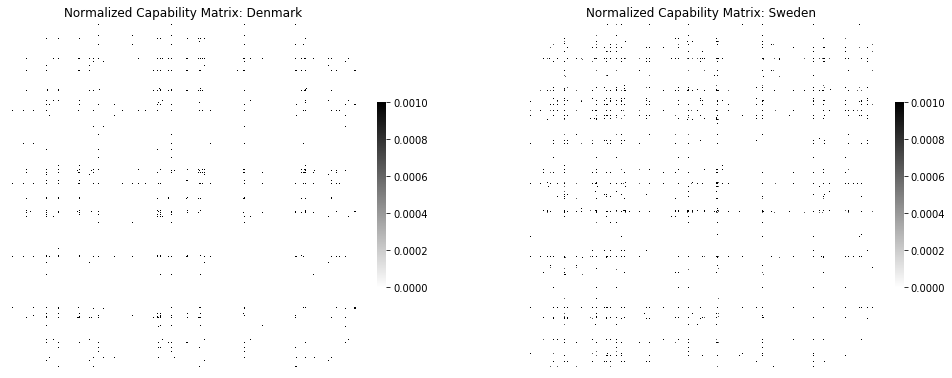

In [7]:
# create subplots
plt.subplots(2,1,figsize=(17,17))

bwhite = 'binary'
vmax = 0.001
vmin=0.00


plt.subplot(121)
sns.heatmap(get_country_matrix('Denmark', normalization=True),cbar=True, cbar_kws={"shrink": .2}, cmap=bwhite, square=True, xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
plt.title('Normalized Capability Matrix: Denmark')

plt.subplot(122)
sns.heatmap(get_country_matrix('Sweden', normalization=True), cbar=True, cbar_kws={"shrink": .2}, cmap=bwhite, square=True, xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
plt.title('Normalized Capability Matrix: Sweden')
plt.show()

### 1.2. Country capability lists <a class="anchor" id="one-two"></a>

One of the goals of the analysis is to understand how each country relates to another. To do this, we will need to transform the matrix of a given country into an array. 

After doing this we will be able to compare the array of each one of the countries, by computing their difference or correlation for example. 

Let's start by creating a function that given a symetric matrix, as the ones shown above, returns a list. This list will have an entry by position in the matrix. But since the matrixes are symmetrical, the list will only receive half of the matrix. 

This means that for a matrix of dimensions 342x342 the list will have a total of 58 482 entries. 

In [8]:
def get_list_from(matrix):
    total_rows = matrix.shape[0]
    only_valuable = []
    extension = 1
    for row_number in range(total_rows):
        only_valuable.append(matrix[row_number, extension:total_rows].tolist()) 
        extension += 1 
    return [element for column in only_valuable for element in column ]

Let's visualize the lists produced by this workflow for two different countries. 

We first select two countries.

In [9]:
spectrum_countries = ['''People's Republic of China''', 'United States of America']

We then create a matrix where each row is the vector that describes the country's capabilities.

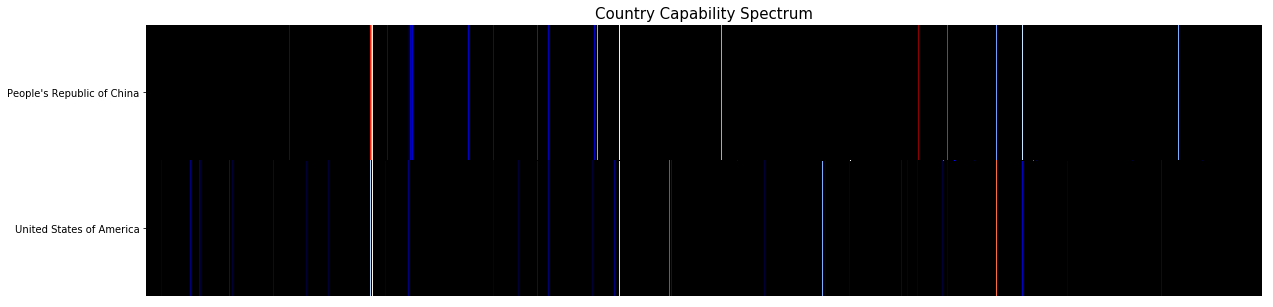

In [10]:
# apply functions to both countries
country_1_list = get_list_from(get_country_matrix(spectrum_countries[0], normalization=True))
country_2_list = get_list_from(get_country_matrix(spectrum_countries[1], normalization=True))

# create a matrix where each row is a list of a country
corelation = np.vstack((country_1_list, country_2_list))

# plot the matrix 


plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(corelation, cmap='flag_r', cbar=None, square=False, yticklabels=[spectrum_countries[0], spectrum_countries[1]], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Country Capability Spectrum', size=15)
plt.show()

We can see that the spectrum differs significantly in some areas. Please note that all of the measure were normalized prior to the plotting.

## 2. Country Correlation Matrix and Profiles <a class="anchor" id="two"></a>

### 2.1. Regular country correlation matrix <a class="anchor" id="two-one"></a>

In this part of the analysis we will start correlating countries in relation to their capabilities. 

The correlation matrix follows the following principle: 
- Entry (i, j) is the correlation index between country i and country j
- The correlation index between country i and j is the absolute average difference between the capability list of country i and j.

Now, taking the list of countries previously established, we can iterate through it and fill the matrix. 

To improve eficiency, we first create a dictionnary where each key is a country, and each value, the capability list.

In the case that the databse contains no assets about a certain country, that country will be discarted. 

In [11]:
# create dictionnary
country_capability_dict = {}
counter = 0

# iterate through countries
for country in country_names:
    counter += 1
    country_matrix = get_country_matrix(country, normalization=True)
    
    # discart if no information
    if np.all(np.isnan(country_matrix)):
        continue
    else: 
        country_capability_dict[country] = get_list_from(country_matrix)

np.save('Data/country_capability_dict.npy', country_capability_dict) 

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning:

invalid value encountered in divide



Let's create a function that given two countries and a method, returns a suitable correlation coeficient. 

Here, the code will give three possible outputs: 
- `abs_avg_dif`: the absolute average difference between two vectors.
- `Pearson`: The [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlation coeficient between two vectors. 
- `P-value`: The p-value according to [scipy](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html).

In [12]:
def calculate_country_correlation(country1_list, country2_list, stat):
    avg_dif = np.mean(country1_list - country2_list)
    abs_avg_dif = abs(avg_dif)
    
    if stat.lower() == 'absolute average difference': # return absolute average difference
        return abs_avg_dif
    if stat == 'Pearson':                             # return Pearson coef
        return stats.pearsonr(country1_list, country2_list)[0]
    if stat == 'P-value':                             # return P-value
        return stats.pearsonr(country1_list, country2_list)[1]

The matrix is built, with the following steps: 
1. For each country, get its asset co-occurence matrix.
2. Normalize the matrix by subtracting the mean and dividing by the standard deviation. 
3. Transform the matrix into a list by taking its upper triangle. 
4. For each entry (i,j) of the matrix, calculate the correlation of the list of country i and the list of country j. 

In [13]:
country_names = country_capability_dict.keys()
country_names.sort()
number_of_countries = len(country_names)
country_correlation = np.zeros([number_of_countries, number_of_countries])


for row in range(number_of_countries):

    country_1 = country_names[row]
    country_1_list = np.asarray(country_capability_dict[country_1])
    for column in range(number_of_countries):
        country_2 = country_names[column]
        country_2_list = np.asarray(country_capability_dict[country_2])

        country_correlation[row, column] = calculate_country_correlation(country_1_list, country_2_list, 'Pearson')
        
np.save('Data/country_correlation.npy', country_correlation)
np.save('Data/country_names.npy', country_names)



In [14]:
print 'Minimum correlation value is {} for countries {} and {}.'.format(country_correlation[np.unravel_index(country_correlation.argmin(), country_correlation.shape)[0],np.unravel_index(country_correlation.argmin(), country_correlation.shape)[1]],country_names[np.unravel_index(country_correlation.argmin(), country_correlation.shape)[0]], country_names[np.unravel_index(country_correlation.argmin(), country_correlation.shape)[1]])

Minimum correlation value is -0.00100362058212 for countries Israel and Netherlands.


After building the matrix, we create the first heatmap of that matrix using the `sns.heatmap` function. 

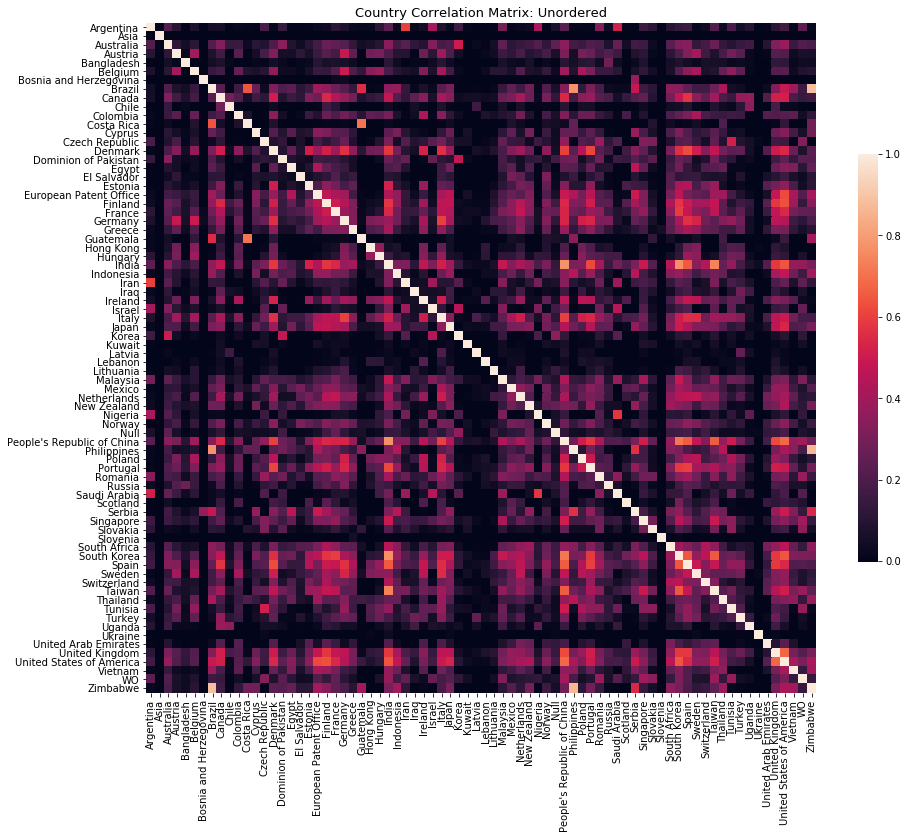

In [15]:
plt.subplots(1,1,figsize=(15, 15))
plt.subplot(111)
sns.heatmap(country_correlation, cbar=True,cbar_kws={"shrink": .5} ,square=True, yticklabels=country_names, xticklabels=country_names)
plt.title('Country Correlation Matrix: Unordered', size=13)
plt.show()

A couple of things worth noting in the first visualization: 
- All of the values of the heatmap are between 0 and 1. 
- A value of 1 indicates the highest level of correlation. For this reason, the diagonal has values equal to 1.(This because it corresponds to the correaltion of a country to itself.) 
- The lighter the color of the correlation, the higher the level of correlation. 
- If a cell in the heatmap is totally dark, this indicates no correlation at all. 

**Light Cell - High Correlation:** This indicates that the capability profile of the two countries concerned is similar. Which can be interpreted as the countries having "similar" research profiles. 

**Dark Cell - Low Correlation:** This indicates that the capability profile of the two countries concerned is different. Which can be interpreted as the countries having divergent research profiles. 

[INTERACTIVE PLOTLY VERSION.](https://plot.ly/~duarteocarmo/24)

### 2.2. Clustered country correlation matrix <a class="anchor" id="two-two"></a>

In this part, we will create a clustermap of the heatmap produced in the previous sections. 

To do this, we use the `sns.clustermap` function (see documentation [here](http://seaborn.pydata.org/generated/seaborn.clustermap.html)) that produces two things: 
- A reordered heatmap according to 'similarity'. This method reorders the matrix using Hierarchical agglomerative clustering with single linkage (minimum distance). See more info about this algorithm [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). 
- This clustermap also creates a [dendogram](https://en.wikipedia.org/wiki/Dendrogram) of the linkages that the algorithm produces.


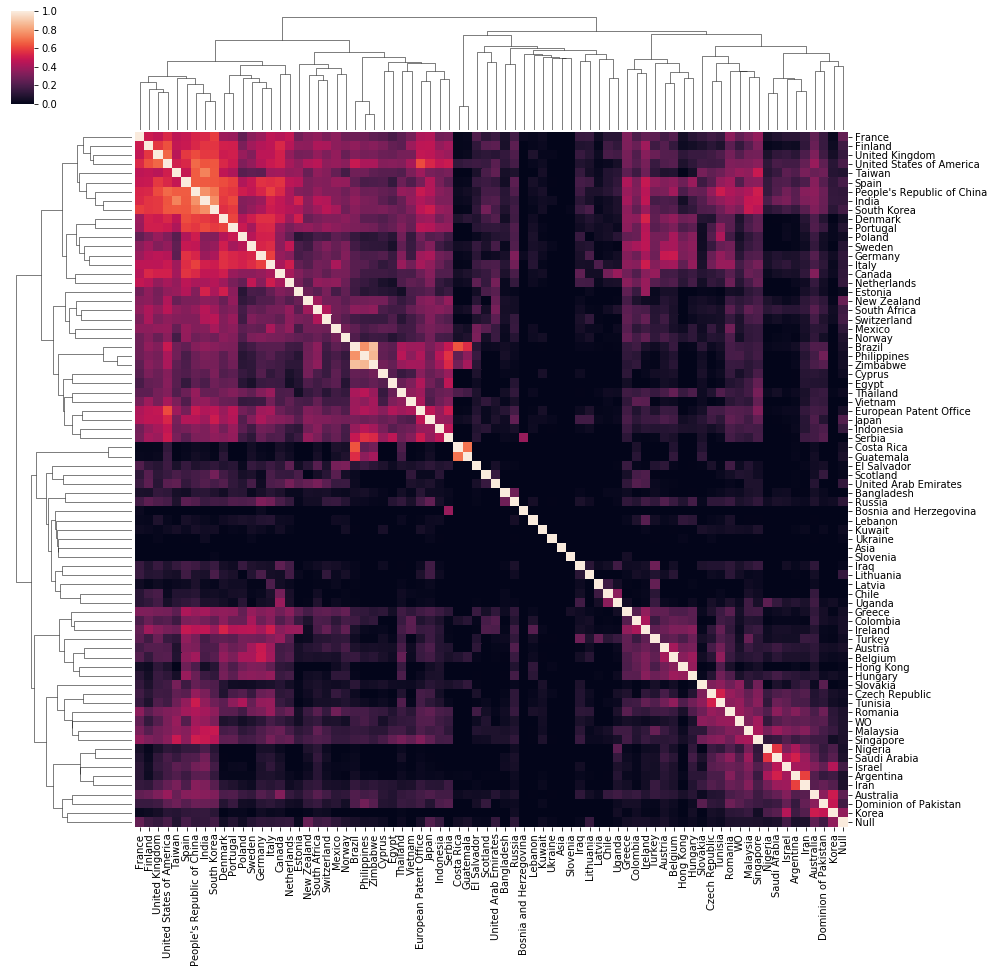

In [16]:
# plot the clustermap
a = sns.clustermap(country_correlation,  figsize=(15, 15), xticklabels = country_names, yticklabels=country_names)
np.save('Data/correlation_matrix.npy', country_correlation)
np.save('Data/correlation_matrix_names.npy', country_names)
plt.show()

Some interesting observations and hypothesis: 
- **Language matters:** UK and USA, for example, are highly correlated. (68% correlation)
- **Distance matters: ** Costa-Rica and Guatemala have a correlation of 71%.
- **Other Factors might matter: **: Portugal and Denmark for example, have a correlation of 61%. 


*PS: the percentage of correlation is achieved by multiplying the Pearson correlation index by 100.* 

### 2.3. Country profiles <a class="anchor" id="two-three"></a>

Another interesting analysis is understanding how one country relates to other countries itself. This is done by *slicing* the heatmap produced in the previous section. 

By producing a bar plot for every country we can see how it relates to others and possibly find meaningful patterns. 

Let's start by selecting a couple of countries:

In [17]:
countries = ['Denmark', 'United Kingdom']

After selecting countries, we can now plot two different profiles. 

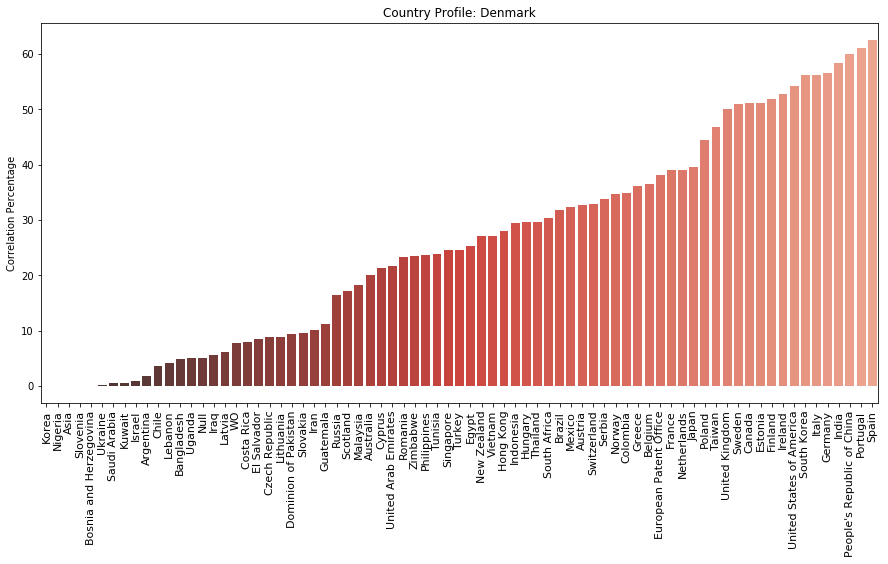

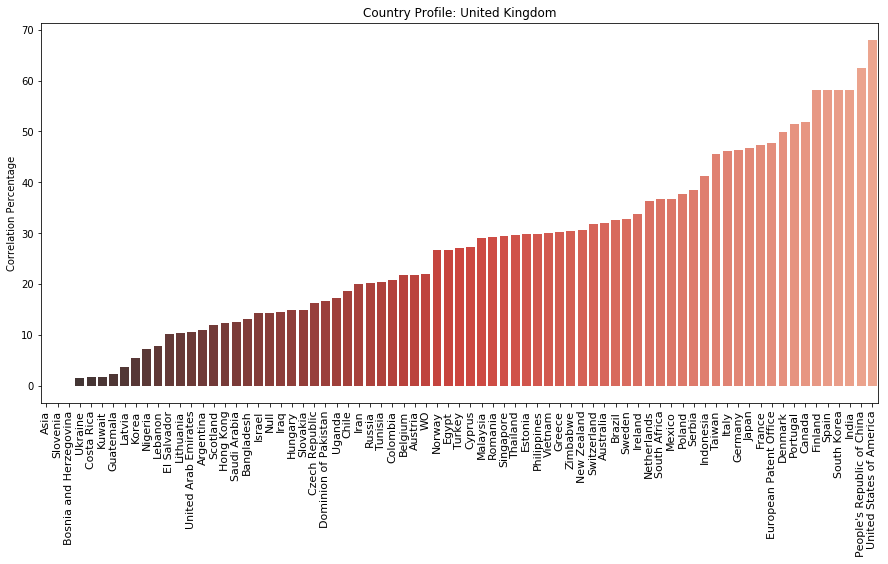

In [18]:
# for each country selected
for country in countries:
    
    # find the matrix slice
    country_index = country_names.index(country)
    histogram_data = country_correlation[:, country_index]
    
    # remove the country itself from data and labels
    histogram_data = np.delete(histogram_data, country_index)
    clean_country_names = np.delete(country_names, country_index)
    

    # sort labels and data
    sorted_names = [name for _,name in sorted(zip(histogram_data, clean_country_names))]
    histogram_data.sort()
    
    #plot
    plt.subplots(1,1,figsize=(15,7))
    sns.barplot(np.arange(len(histogram_data)), histogram_data * 100, palette="Reds_d")
    plt.xticks(np.arange(len(histogram_data)), sorted_names, rotation=90, fontsize=11)
    plt.title('Country Profile: {}'.format(country))
    plt.ylabel('Correlation Percentage')
    plt.show()

[INTERACTIVE PLOTLY VERSION](https://plot.ly/~duarteocarmo/26)

Some important information comes from these profiles: 
- Using these profile we can dive deeper into each country to confirm the above hypothesis. 
- Looking at UK's profile, the top three countries with highest correlation with it are: USA, China and India. This can mean that language is a very important factor for correlation but also eceonomic development for example. 
- Looking at Denmark's profile, the 3 most similar countries are: Spain, Portugal and China. This indicates that there is possibly another important factor at play. 

## 3. Contextual Relations <a class="anchor" id="three"></a>

We will now study the relationship between the previously found correlations and other characteristics. 

### 3.1. GDP per capita <a class="anchor" id="three-one"></a>


Let us investigate how the GDP per capita is related to the country capabilities. 

The world bank has data available on the GDP per capita for (almost) every country in the world. 

[Source](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)

Let us investigate what countries or elements are not available in the World Bank database: 

In [19]:
data = pd.read_csv('Data/GDP_per_capita.csv', delimiter=';', header=None).as_matrix()
print 'Countries that do not have data:'

for country in country_names:
    if country not in data[:, 0]:
        print country

Countries that do not have data:
Asia
Null


#### 3.1.1. GDP per capita and capabilities <a class="anchor" id="three-one-one"></a>

We delete these entries from the `country_correlation` matrix (our heatmap) and create an `adapted_country_correlation` that is equal, without the entries that do not have GDP data available. 

In [20]:
countries_not_available = ['Asia', 'Null', 'Korea']
index_countries_not_available = [country_names.index(country) for country in countries_not_available]

adapted_country_correlation = np.delete(country_correlation, index_countries_not_available, 0)
adapted_country_correlation = np.delete(adapted_country_correlation, index_countries_not_available, 1)

Next, we create a matrix where the GDP's are correlated with each other. Following the structure: 
- Entry(i,j) is the absolute value of the difference between the GDP per capita of country i and j.

In [21]:
# create the matrix
gdps = np.zeros([adapted_country_correlation.shape[0], adapted_country_correlation.shape[0]])
countries_available = [country for country in country_names if country not in countries_not_available]
countries_available.sort()

# for every entry, calculate the entry
for row in range(len(countries_available)):
    country_1 = countries_available[row]
    country_1_gdp = float(data[data[:, 0].tolist().index(country_1), 1])
    for column in range(len(countries_available)):
        country_2 = countries_available[column]
        country_2_gdp = float(data[data[:, 0].tolist().index(country_2), 1])
    
        gdps[row, column] = abs(country_1_gdp - country_2_gdp)
        
        

gdps_norm = (gdps - np.mean(gdps)) / np.std(gdps)

We can finally plot the GDP per capita difference heatmap. 

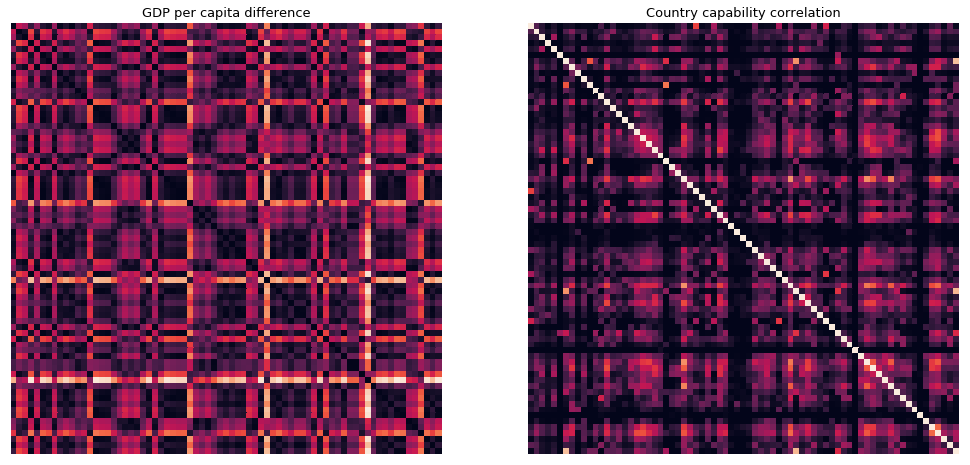

In [22]:
plt.subplots(1,2,figsize=(17,17))

plt.subplot(121)
sns.heatmap(gdps, square=True, cbar=None, yticklabels=False, xticklabels=False)
plt.title('GDP per capita difference', size=13)

plt.subplot(122)
sns.heatmap(adapted_country_correlation, square=True, cbar=None, yticklabels=False, xticklabels=False)
plt.title('Country capability correlation', size=13)
plt.show()

**Left Figure**:  The difference in GDP per capita of all of the countries in the database. The lighter the color in the heatmap, the bigger the difference in the GDP per capita between two countries. 

**Rigth Figure**: The knowledge capability correlation between two countries. The lighter the color, the more correlated their capabilities are. 

Let's study if these two matrixes are correlated in any way. We start by creating a function that flattens the above matrixes, by takingthe upper triangle and discarting anything below it (including the diagonal). 

In [23]:
def custom_flatten(matrix):
    rows = matrix.shape[0]
    cols = matrix.shape[1]
    
    finalList = []
    columnDisplacement = 1 
    for rowNumber in range(rows):
        listToAppend =  matrix[rowNumber, :][columnDisplacement::]
        finalList.extend(listToAppend)
        
        columnDisplacement += 1
    return finalList 

After doing so, we determine two relevant statistics for the correlation study: 

In [24]:
rounding = 4
pearson_ = stats.pearsonr(custom_flatten(gdps), custom_flatten(adapted_country_correlation))[0]
p_value = stats.pearsonr(custom_flatten(gdps), custom_flatten(adapted_country_correlation))[1]
cos_sim = 1 - spatial.distance.cosine(custom_flatten(gdps), custom_flatten(adapted_country_correlation))

print 'Pearson correlation Index: {} (p-value of {})'.format(round(pearson_, rounding), round(p_value, rounding))
print 'Cosine similarity: {}'.format(round(cos_sim, rounding))

Pearson correlation Index: 0.0392 (p-value of 0.0446)
Cosine similarity: 0.5621


The pearson correlation index shows that there is a very small positive correlation between GDP per capita and capability. Moreover, the p-value (< 0.05)comes to show that this assessment is 'statistically relevant'.

#### 3.1.2. Country Profiles and Correlation <a class="anchor" id="three-one-two"></a>

**Global Correlations - Scatter Plot**

As can be noticed above, there are a lot of country pairs that have a 0 capability correlation. This can happen for severall reasons: 
- One of the countries does not have a significant number of assets. 
- Both countries have a very low number of assets. 

To understant the reach of this trait, the same plot is reproduced whyle ignoring the country pairs with 0 capability correlation. 

Let us plot some guiding lines that will help us visualize the logic of this plot:

A total of 633 entries were eliminated from 2628.


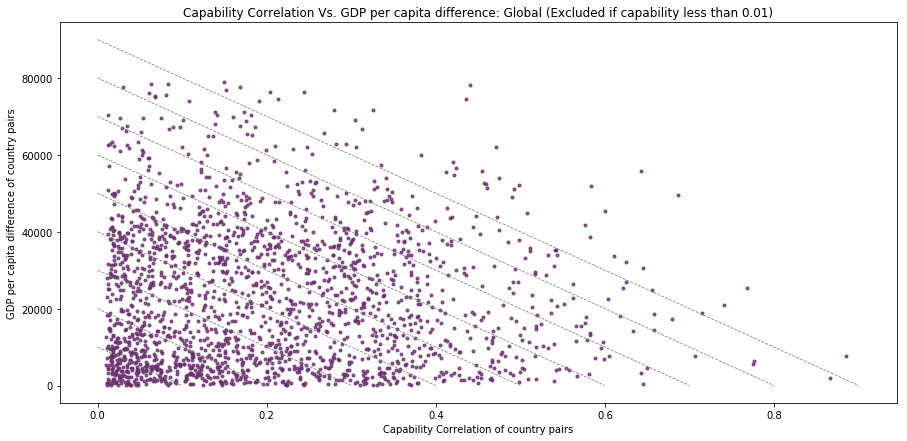

In [25]:
# create global lists for gdps difference and 
globalGDP = np.asarray(custom_flatten(gdps))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))

# eliminate pairs with no correlation 
capabilityThreshold = 0.01
globalGDP_notNull = globalGDP[globalCapabilityCorrelation > capabilityThreshold]
globalCapabilityCorrelation_notNull = globalCapabilityCorrelation[globalCapabilityCorrelation  > capabilityThreshold]


print 'A total of {} entries were eliminated from {}.'.format(len(globalCapabilityCorrelation) - len(globalCapabilityCorrelation_notNull), len(globalCapabilityCorrelation))

# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(globalCapabilityCorrelation_notNull, globalGDP_notNull,fit_reg=False, marker=".", color = '#69306d')

x1 = 0.0 
x2 = 0.1
y1 = 10000
y2 = 0

for k in range(9):    
    plt.plot([x1, x2], [y1, y2], ls="--", c='grey', lw=0.8)
    y1 = y1 + 10000
    x2 = x2 + 0.1


plt.xlabel('Capability Correlation of country pairs')
plt.ylabel('GDP per capita difference of country pairs')
plt.title('Capability Correlation Vs. GDP per capita difference: Global (Excluded if capability less than {})'.format(capabilityThreshold))
plt.show()

Let us investigate some outliers:

In [26]:
gdpPerCapitaLowerLimit = 45000
capabilityCorrelationLowerLimit = 0.5

print 'Outliers'
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if np.triu(gdps, 1)[i,j]>gdpPerCapitaLowerLimit and np.triu(adapted_country_correlation, 1)[i,j]> capabilityCorrelationLowerLimit:
            print countries_available[i],'-', countries_available[j]
                

Outliers
Denmark - India
Denmark - People's Republic of China
India - United States of America
People's Republic of China - United States of America


**Global Correlations- Density Plot**

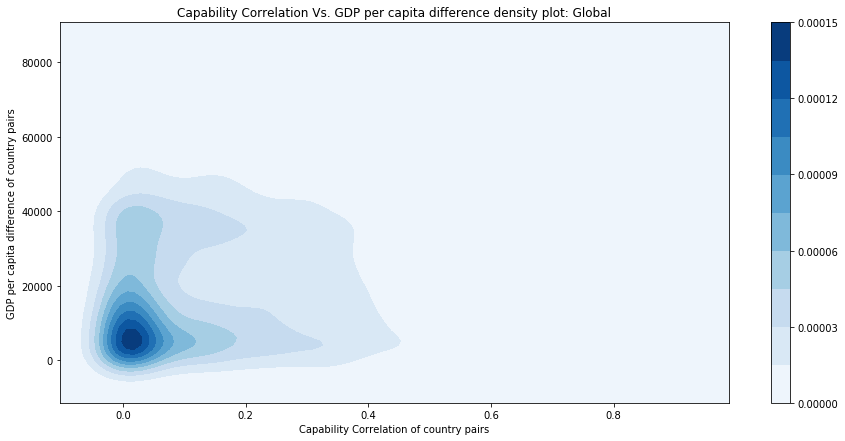

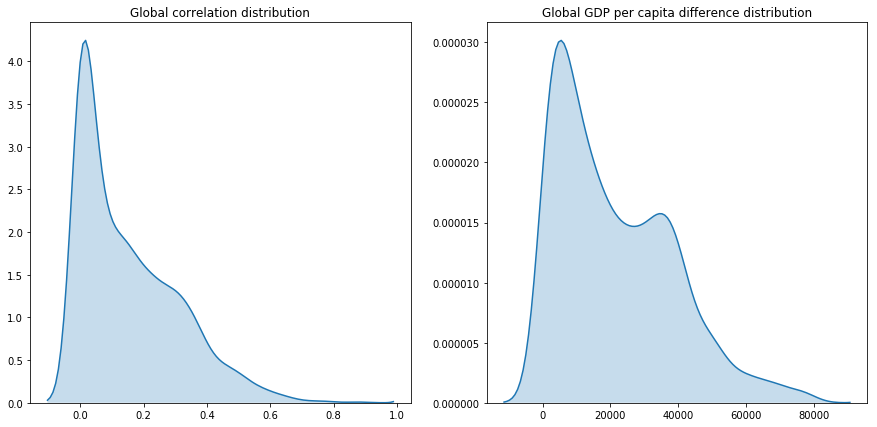

In [27]:
# density plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.kdeplot(globalCapabilityCorrelation, globalGDP, cmap="Blues", shade=True, cbar = True)
plt.xlabel('Capability Correlation of country pairs')
plt.ylabel('GDP per capita difference of country pairs')
plt.title('Capability Correlation Vs. GDP per capita difference density plot: Global')
plt.show()



plt.subplots(1,2,figsize=(15,7))

plt.subplot(121)
sns.kdeplot(globalCapabilityCorrelation,  shade=True)
plt.title('Global correlation distribution')


plt.subplot(122)
sns.kdeplot(globalGDP,  shade=True)
plt.title('Global GDP per capita difference distribution')
plt.show()

#### 3.1.3. Using the average GDP per capita <a class="anchor" id="three-one-three"></a>

In this part of the analysis we will introduce the average gdp per capita between two countries, let's start by creating the matrix.

In [28]:
# create the matrix
gdps_average = np.zeros([adapted_country_correlation.shape[0], adapted_country_correlation.shape[0]])
countries_available = [country for country in country_names if country not in countries_not_available]
countries_available.sort()

# for every entry, calculate the entry
for row in range(len(countries_available)):
    country_1 = countries_available[row]
    country_1_gdp = float(data[data[:, 0].tolist().index(country_1), 1])
    for column in range(len(countries_available)):
        country_2 = countries_available[column]
        country_2_gdp = float(data[data[:, 0].tolist().index(country_2), 1])
    
        gdps_average[row, column] = (country_1_gdp + country_2_gdp) / 2.0

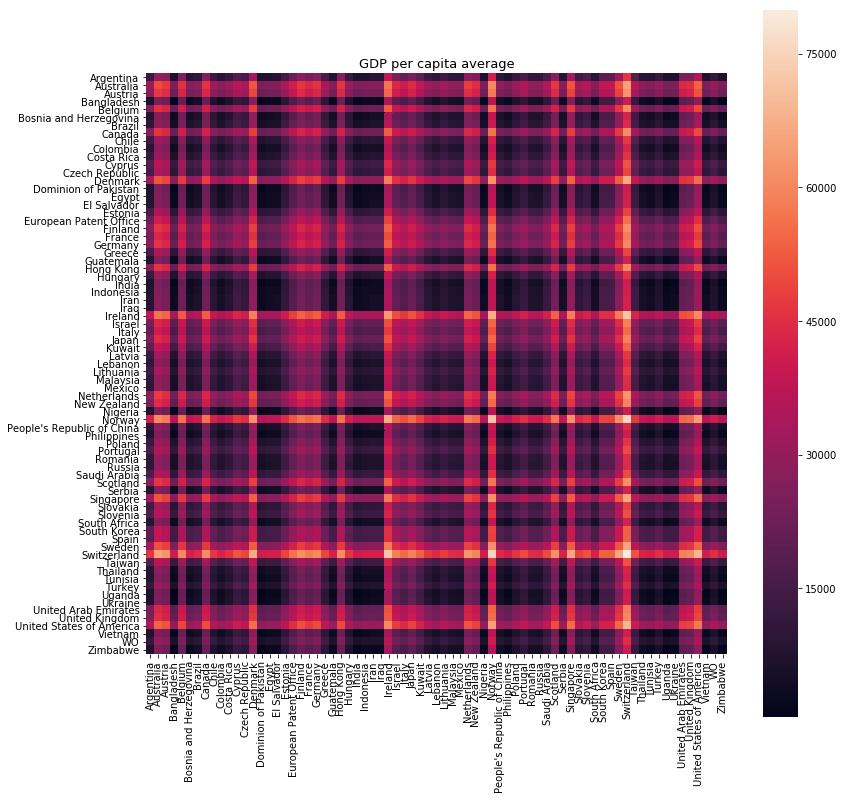

In [29]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(gdps_average, square=True, cbar=True, yticklabels=countries_available, xticklabels=countries_available)
plt.title('GDP per capita average', size=13)
plt.show()

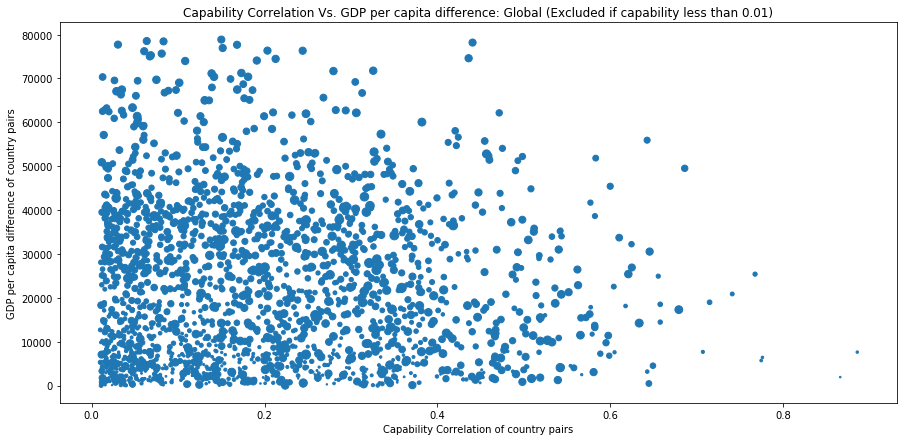

In [30]:
globalGDP = np.asarray(custom_flatten(gdps))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))
globalGdpAverage = np.asarray(custom_flatten(gdps_average)) / 800

# eliminate pairs with no correlation 
capabilityThreshold = 0.01
globalGDP_notNull = globalGDP[globalCapabilityCorrelation > capabilityThreshold]
globalCapabilityCorrelation_notNull = globalCapabilityCorrelation[globalCapabilityCorrelation  > capabilityThreshold]
globalGdpAverage_notNull = globalGdpAverage[globalCapabilityCorrelation  > capabilityThreshold]

# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
plt.scatter(globalCapabilityCorrelation_notNull, globalGDP_notNull, s=globalGdpAverage_notNull, marker="o")
plt.xlabel('Capability Correlation of country pairs')
plt.ylabel('GDP per capita difference of country pairs')
plt.title('Capability Correlation Vs. GDP per capita difference: Global (Excluded if capability less than {})'.format(capabilityThreshold))
plt.show()

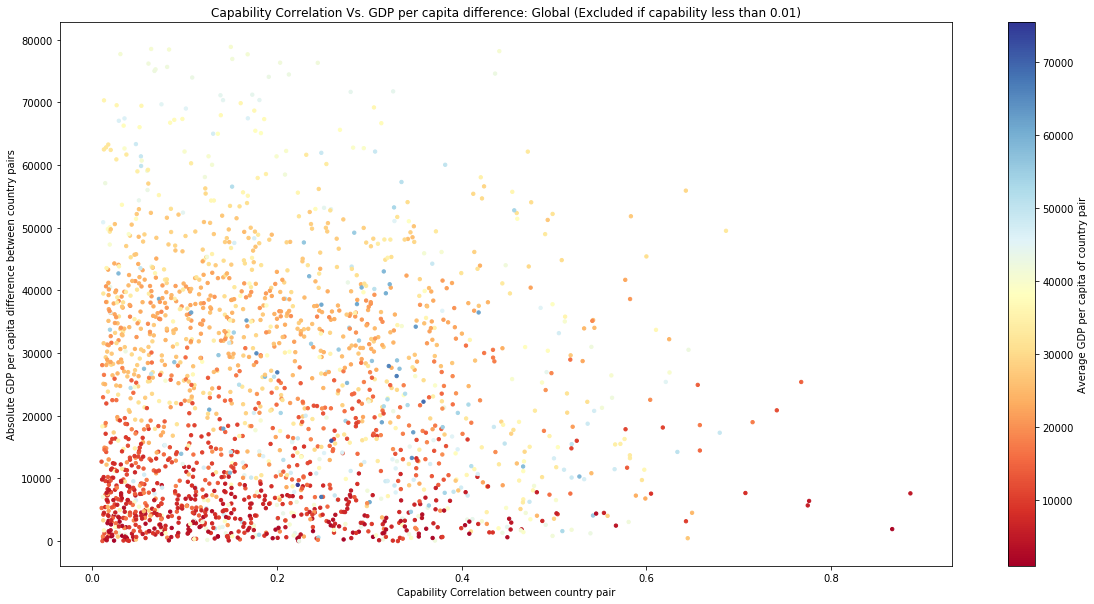

In [31]:
globalGDP = np.asarray(custom_flatten(gdps))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))
globalGdpAverage = np.asarray(custom_flatten(gdps_average))

# eliminate pairs with no correlation 
capabilityThreshold = 0.01
globalGDP_notNull = globalGDP[globalCapabilityCorrelation > capabilityThreshold]
globalCapabilityCorrelation_notNull = globalCapabilityCorrelation[globalCapabilityCorrelation  > capabilityThreshold]
globalGdpAverage_notNull = globalGdpAverage[globalCapabilityCorrelation  > capabilityThreshold]

# scatter plot
fig, ax1 = plt.subplots(figsize=(20,10))
cm = plt.cm.get_cmap('RdYlBu')
hey = plt.scatter(globalCapabilityCorrelation_notNull, globalGDP_notNull, c=globalGdpAverage_notNull, s=45, marker=".", cmap=cm)
plt.xlabel('Capability Correlation between country pair')
plt.ylabel('Absolute GDP per capita difference between country pairs')
plt.title('Capability Correlation Vs. GDP per capita difference: Global (Excluded if capability less than {})'.format(capabilityThreshold))
cb = plt.colorbar(hey)
cb.set_label('Average GDP per capita of country pair')

plt.show()

Interactive version [here.](https://plot.ly/~duarteocarmo/32)

In [32]:
data_points_names = []
column_dis = 1
for i in range(len(countries_available)):
    first_name = countries_available[i]
    data_points_names.extend([(first_name, e) for e in countries_available[column_dis::]])
    column_dis += 1

    
print 'Total numbers:'    
print 'Lenght of name pairs: ', len(data_points_names)
print 'Length of data points: ', len(globalGDP)
        
country1 = 'Brazil'
country2 = 'Zimbabwe'

print 'For {} and {}'.format(country1, country2)
for i in range(len(data_points_names)):
    if data_points_names[i] == (country1, country2):
        index = i
    if data_points_names[i] == (country2, country1):
        index = i


print 'Index is: ', index
print 'GDP Difference: ',globalGDP[index]
print 'GDP Average: ',globalGdpAverage[index]
print 'Capability Correlation: ',globalCapabilityCorrelation[index]

Total numbers:
Lenght of name pairs:  2628
Length of data points:  2628
For Brazil and Zimbabwe
Index is:  482
GDP Difference:  7620.871843072169
GDP Average:  4839.512570214535
Capability Correlation:  0.8857330718451609


### 3.2. Collaborations <a class="anchor" id="three-two"></a>

#### 3.2.1. Collaboration Matrix <a class="anchor" id="three-two-one"></a>

The goal of this part of the analysis is to understand if the number of collaborations between countries plays a part in their correlation.

To understand this let us create a matrix of collaborations.

We start by creating the right query and building the matrix. 

In [33]:
# create Query 
colabQuery = """ MATCH (a:Asset)-[:LOCATED_IN]->(ac:Country)
            MATCH (b:Asset)-[:LOCATED_IN]->(bc:Country)
            WHERE a.id = b.id AND ac.name <> bc.name
            RETURN ac.name, bc.name ,count(a.id)
            ORDER BY count(a.id) DESC"""

# extract matrix from query
colabData = DataFrame(connection_to_graph.data(colabQuery)).as_matrix()

# create empty collaboration matrix 
colabMatrix = np.zeros([adapted_country_correlation.shape[0], adapted_country_correlation.shape[0]])

for row in range(len(countries_available)):
    firstCountry = countries_available[row]
    for col in range(len(countries_available)):
        secondCountry = countries_available[col]
        
        # if first and second country match, put value in matrix and break loop. 
        for data_row in colabData:
            if firstCountry == data_row[0] and secondCountry == data_row[1]:
                found = 1
                colabMatrix[row,col] = data_row[2]
                break

We start by plotting the heatmap of our collaboration matrix. 

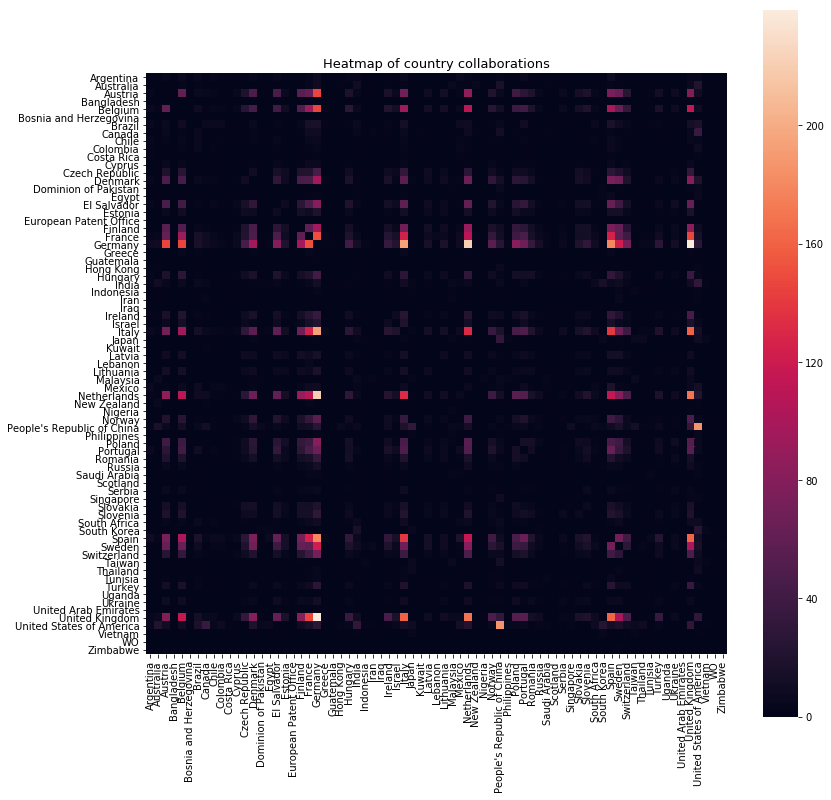

In [34]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(colabMatrix, square=True, yticklabels=countries_available, xticklabels=countries_available)
plt.title('Heatmap of country collaborations', size=13)
plt.show()

Let us create a verification tool to understand if everything is working properly. 

In [35]:
firstCountry= 'Germany'
secondCountry= 'United Kingdom'


firstIndex = countries_available.index(firstCountry)
secondIndex = countries_available.index(secondCountry)

print '{} and {} have {} assets in common. Value: {}; Symmetrical Value: {}.'.format(firstCountry, secondCountry, colabMatrix[firstIndex, secondIndex], colabMatrix[firstIndex, secondIndex], colabMatrix[secondIndex, firstIndex])

Germany and United Kingdom have 239.0 assets in common. Value: 239.0; Symmetrical Value: 239.0.


This corresponds to the neo4j value found in the database.

#### 3.2.2. Collaborations and Capabilities <a class="anchor" id="three-two-two"></a>

We now seek to understand the relationship between collaborations and capacbility correlation in our data. 

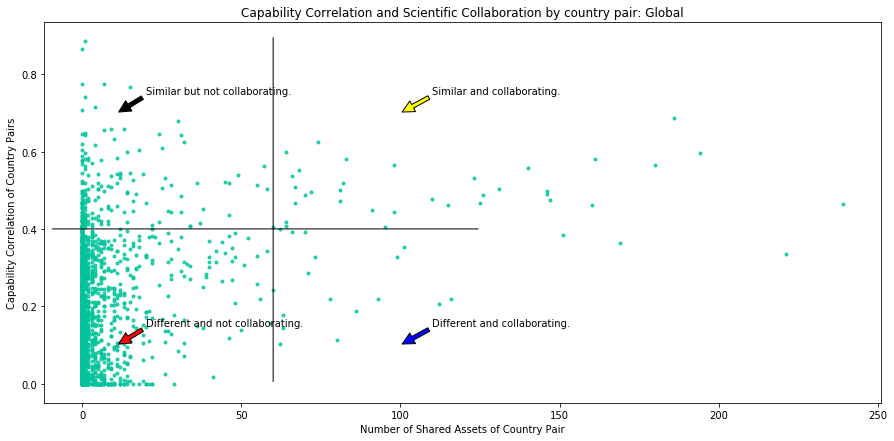

The pearson correlation between these two variables is 0.34187483862 with a p-value of 6.05434132733e-73.


In [36]:
# create global lists for gdps difference and 
globalCollaborations = np.asarray(custom_flatten(colabMatrix))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))

# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(globalCollaborations, globalCapabilityCorrelation,fit_reg=False, marker=".", color = '#02c39a')
plt.ylabel('Capability Correlation of Country Pairs')
plt.xlabel('Number of Shared Assets of Country Pair')
plt.title('Capability Correlation and Scientific Collaboration by country pair: Global')

# annotations
plt.annotate('Similar but not collaborating.', xy=(11, 0.7), xytext=(20, 0.75),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Different and not collaborating.', xy=(11, 0.1), xytext=(20, 0.15),arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('Similar and collaborating.', xy=(100, 0.7), xytext=(110, 0.75),arrowprops=dict(facecolor='yellow', shrink=0.05))
plt.annotate('Different and collaborating.', xy=(100, 0.1), xytext=(110, 0.15),arrowprops=dict(facecolor='blue', shrink=0.05))
plt.annotate("",xy=(60, 0.0), xycoords='data',xytext=(60, 0.9), textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="arc3"),)
plt.annotate("",xy=(-10, 0.4), xycoords='data',xytext=(125, 0.4), textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="arc3"),)


plt.show()

# get correlation score
correlation_score = stats.pearsonr(globalCapabilityCorrelation, globalCollaborations)

print 'The pearson correlation between these two variables is {} with a p-value of {}.'.format(correlation_score[0], correlation_score[1])

In [37]:
print 'Different and not Collaborating:'
counter = 0
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if colabMatrix[i,j]<60 and adapted_country_correlation[i,j]< 0.4:
            print countries_available[i],'-', countries_available[j]
            counter += 1
            break     
    if counter == 4:
        break

Different and not Collaborating:
Argentina - Australia
Australia - Argentina
Austria - Argentina
Bangladesh - Argentina


In [38]:
print 'Different and Collaborating:'
counter = 0
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if colabMatrix[i,j]>60 and adapted_country_correlation[i,j]< 0.4:
            print countries_available[i],'-', countries_available[j]
            counter += 1
            break     
    if counter == 4:
        break

Different and Collaborating:
Austria - France
Belgium - France
Denmark - Netherlands
El Salvador - Germany


In [39]:
print 'Similar but not Collaborating:'
counter = 0
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if colabMatrix[i,j]<60 and adapted_country_correlation[i,j]> 0.4 and adapted_country_correlation[i,j]< 0.8:
            print countries_available[i],'-', countries_available[j]
            counter += 1
            break     
    if counter == 4:
        break

Similar but not Collaborating:
Argentina - Iran
Belgium - People's Republic of China
Brazil - Costa Rica
Canada - Denmark


In [40]:
print 'Similar and Collaborating:'
counter = 0
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if colabMatrix[i,j]>75 and adapted_country_correlation[i,j]> 0.4 and adapted_country_correlation[i,j]< 0.8:
            print countries_available[i],'-', countries_available[j]
            counter += 1
            break     
    if counter == 4:
        break

Similar and Collaborating:
Austria - Germany
Belgium - Germany
Denmark - Germany
Finland - Germany


#### 3.2.3. Normalized Collaborations and Capabilities <a class="anchor" id="three-two-three"></a>

In order to more deeply understand the relationship between collaborations and capabilities, we will normalized the collaborations part of the procedure. To do this, we must specify: 
- Old collaboration definition: Country `i` and country `j` have `z` assets that have both their name as location. 
- New **normalized** collaboration definition: 
`normalized_collaboration`= (` number of shared assets between country i and j`)/(` number of total possible collaborations between i and j`)

Let us create a function that given a country returns its number of assets. 

In [41]:
def get_asset_number(country):
    numberQuery = """   MATCH (a:Asset)-[:LOCATED_IN]->(ac:Country)
                        WHERE ac.name = "{}"
                        RETURN count(a)""".format(country)
    return DataFrame(connection_to_graph.data(numberQuery)).as_matrix()[0][0]

And we create the `normalizedColabMatrix`:

In [42]:
normalizedColabMatrix = np.zeros(adapted_country_correlation.shape)

for rowNumber in range(len(countries_available)):
    first_country = countries_available[rowNumber]
    first_country_assets = get_asset_number(first_country)
    for colNumber in range(len(countries_available)):
        second_country = countries_available[colNumber]
        second_country_assets = get_asset_number(second_country)
        
        normalizedColabMatrix[rowNumber, colNumber] = colabMatrix[rowNumber, colNumber] / min(first_country_assets, second_country_assets)

Let us check if everything is working properly: 

In [43]:
country_1 = 'Denmark'
country_2 = 'Portugal'

country_1_index = countries_available.index(country_1)
country_2_index = countries_available.index(country_2)

print 'Number of assets {}: '.format(country_1), get_asset_number(country_1)
print 'Number of assets {}: '.format(country_2), get_asset_number(country_2)
print 'Number of shared assets: ', colabMatrix[country_1_index, country_2_index]
print 'Number of normalized shared assets: ', normalizedColabMatrix[country_1_index, country_2_index]

Number of assets Denmark:  351
Number of assets Portugal:  180
Number of shared assets:  25.0
Number of normalized shared assets:  0.1388888888888889


Since the maximum number of shared assets in this case is 180, the normalized shared assets as described above should be 25/180, which is indeed equal to 0.14.

We can now reproduce a scatter plot where:
- the `x` axis corresponds to the number of **normalized** shared assets between a country pair
- the `y` axis corresponds to the capability correlation for that same country pair. 

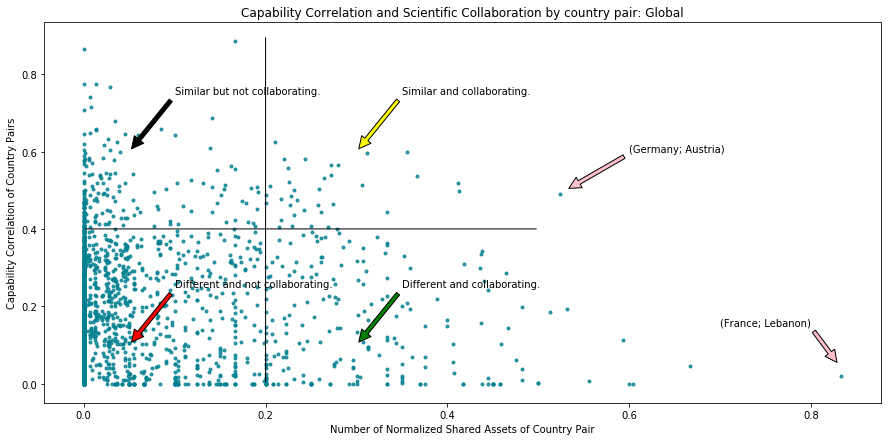

The pearson correlation between these two variables is 0.129905773557 with a p-value of 2.31450323545e-11.
Capability Correlation Mean:  0.15269746827174693
Normalized Collaboration Mean:  0.04922511209177974


In [44]:
# create global lists for gdps difference and 
globalNormalizedCollaborations = np.asarray(custom_flatten(normalizedColabMatrix))
globalCapabilityCorrelation = np.asarray(custom_flatten(adapted_country_correlation))

# scatter plot
fig, ax1 = plt.subplots(figsize=(15,7))
sns.regplot(globalNormalizedCollaborations, globalCapabilityCorrelation,fit_reg=False, marker=".", color = '#028090')
plt.ylabel('Capability Correlation of Country Pairs')
plt.xlabel('Number of Normalized Shared Assets of Country Pair')
plt.title('Capability Correlation and Scientific Collaboration by country pair: Global')

# annotations
plt.annotate('Similar but not collaborating.', xy=(0.05, 0.6), xytext=(0.1, 0.75),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Different and not collaborating.', xy=(0.05, 0.1), xytext=(0.1, 0.25),arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('Similar and collaborating.', xy=(0.3, 0.6), xytext=(0.35, 0.75),arrowprops=dict(facecolor='yellow', shrink=0.05))
plt.annotate('Different and collaborating.', xy=(0.3, 0.1), xytext=(0.35, 0.25),arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate("",xy=(0.2, 0.0), xycoords='data',xytext=(0.2, 0.9), textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="arc3"),)
plt.annotate("",xy=(0, 0.4), xycoords='data',xytext=(0.5, 0.4), textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="arc3"),)
plt.annotate('(France; Lebanon)', xy=(0.83, 0.05), xytext=(0.7, 0.15),arrowprops=dict(facecolor='pink', shrink=0.05))
plt.annotate('(Germany; Austria)', xy=(0.53, 0.5), xytext=(0.6, 0.6),arrowprops=dict(facecolor='pink', shrink=0.05))


plt.show()

# get correlation score
correlation_score = stats.pearsonr(globalCapabilityCorrelation, globalNormalizedCollaborations)

print 'The pearson correlation between these two variables is {} with a p-value of {}.'.format(correlation_score[0], correlation_score[1])
print 'Capability Correlation Mean: ', np.mean(globalCapabilityCorrelation)
print 'Normalized Collaboration Mean: ', np.mean(globalNormalizedCollaborations)

Interactive version [here.](https://plot.ly/~duarteocarmo/34/)

Let us analyze some of the datapoints:

In [45]:
print 'Different and Collaborating (Limited):'
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if np.triu(normalizedColabMatrix, 1)[i,j]>0.5 and np.triu(adapted_country_correlation, 1)[i,j]<0.4:
            print countries_available[i],'-', countries_available[j]   

Different and Collaborating (Limited):
Canada - Kuwait
El Salvador - Germany
Estonia - Germany
France - Lebanon
Germany - Latvia
Germany - Lithuania
Germany - Slovenia
Germany - Ukraine


In [46]:
print 'Similar and Collaborating (Limited):'
for i in range(len(countries_available)):
    for j in range(len(countries_available)):
        if np.triu(normalizedColabMatrix, 1)[i,j]>0.3 and np.triu(adapted_country_correlation, 1)[i,j]>0.4:
            print countries_available[i],'-', countries_available[j]

Similar and Collaborating (Limited):
Austria - Germany
Belgium - Germany
Estonia - Spain
Germany - Italy
Germany - Poland
Germany - Portugal
Portugal - Spain
Portugal - United Kingdom


## 4. Comparing countries <a class="anchor" id="four"></a>

### 4.1. Visualizing Differences <a class="anchor" id="four-one"></a>

We will start by producing a macro visualization of the capability matrix of Denmark and the capability matrix of Sweden. For now, we will not focus on the exact capabilities taht differ, but just compare them side by side, without normalizing. 

We use the functions previsouly produced. 

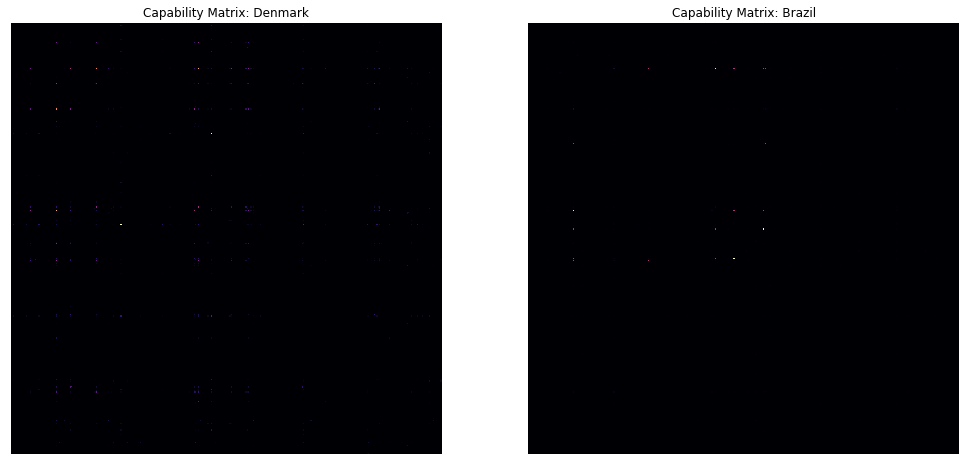

In [47]:
# call functions
denmark = 'Denmark'
compare_with = 'Brazil'
colors = 'magma'
dk_matrix = get_country_matrix(denmark, normalization=False)
scnd_matrix = get_country_matrix(compare_with, normalization=False)

# create a subplot
plt.subplots(2,1,figsize=(17,17))

# first heatmap
plt.subplot(121)
sns.heatmap(dk_matrix, cmap=colors,  cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix: {}'.format(denmark))

# second heatmap
plt.subplot(122)
sns.heatmap(scnd_matrix, cmap=colors, cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Capability Matrix: {}'.format(compare_with))
plt.show()

Next, let us create the map of differences, where: 

differences[i, j] = abs(denmark[i,j] - other_country[i, j]) for every i and j

In [48]:
cap_diff = np.absolute(dk_matrix - scnd_matrix)

And plot the heatmap

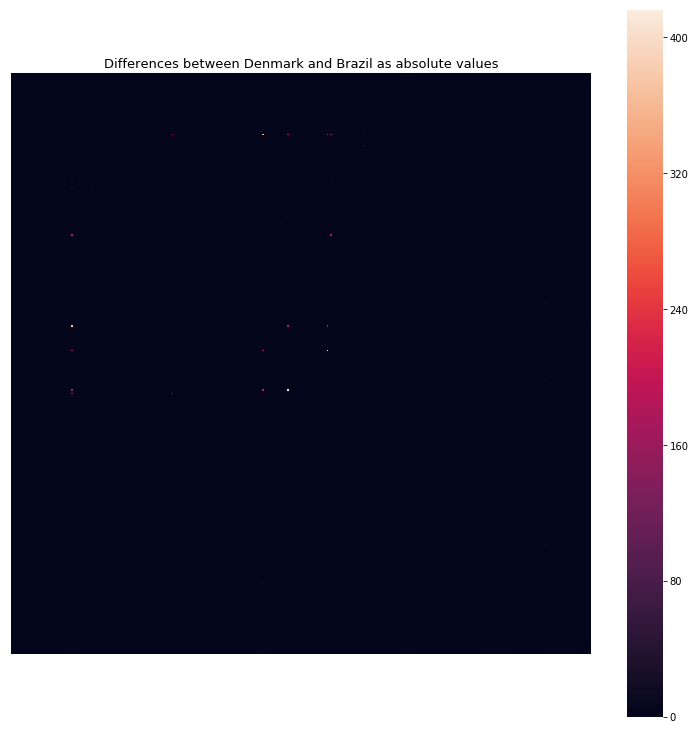

In [49]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(cap_diff, square=True, yticklabels=False, xticklabels=False)
plt.title('Differences between Denmark and {} as absolute values'.format(compare_with), size=13)
plt.show()

### 4.2. Understanding Differences <a class="anchor" id="four-two"></a>

Let us analyze the capability pairs where denmark and the other country have the most documents. 

We create a function that given a matrix, returns its top hits. 

In [50]:
def get_top_hits(countryMatrix, name):
    """
    The function prints the top occurences if fed a matrix of occurences, it also prints other types of valuable info.
    WARNING: Percentages are shown as 0 to 1. 
    """
        
    # list where all the values and indexes of matrix are stored
    top = 10
    values = []
    indexes = []
    no_duplicates = np.triu(countryMatrix, 1)
    total_documents = np.sum(no_duplicates)
    
    
    # loop through the matrix
    for row_n in range(dk_matrix.shape[0]):
        for col_n in range(dk_matrix.shape[1]):
            values.append(no_duplicates[row_n, col_n])
            indexes.append((row_n, col_n))
    
    
    # order the indexes and get the top
    Z = [indexes for _,indexes in sorted(zip(values,indexes))]
    extremes = Z[-top :]
    
    
    # create dataframe
    term_Dataframe = pd.DataFrame(
        {'First Term': [matrix_axis_names[e[0]] for e in extremes],
         'Second Term': [matrix_axis_names[e[1]] for e in extremes],
         'Number of Documents': [int(no_duplicates[e[0], e[1]]) for e in extremes], 
         'Percentage' : [no_duplicates[e[0], e[1]] / float(total_documents) for e in extremes], 
        })
    
    # prepare dataframe
    term_Dataframe = term_Dataframe[['First Term', 'Second Term','Number of Documents', 'Percentage']]
    term_Dataframe = term_Dataframe.sort_values('Number of Documents', ascending=False)
    
    
    # print everything
    print 'The top hits for the {} matrix: '.format(name)
    display(HTML(term_Dataframe.to_html(index=False)))
    
    
    print 'The total number of documents is {}.'.format(int(total_documents))
    print 'Note: Percentages are as 0-1 in this table. '

And we run the function on both our countries. 

Denmark:

In [51]:
get_top_hits(dk_matrix, denmark)

The top hits for the Denmark matrix: 


First Term,Second Term,Number of Documents,Percentage
anaerobic digestion,biogas,31,0.038994
ethanol,fermentation,26,0.032704
ethanol,hydrolysis,23,0.028931
ethanol,straw,14,0.017610
bioethanol,fermentation,14,0.017610
yeast,fermentation,12,0.015094
ethanol,enzymatic hydrolysis,12,0.015094
ethanol,cellulosic ethanol,12,0.015094
hydrolysis,bioethanol,12,0.015094
fermentation,cellulosic ethanol,11,0.013836


The total number of documents is 795.
Note: Percentages are as 0-1 in this table. 


We notice that outputs play a major role in the capability matrix. Biogas, ethanol and fermentation are some of the terms that appear the most. 

And the other country. 

In [52]:
get_top_hits(scnd_matrix, compare_with)

The top hits for the Brazil matrix: 


First Term,Second Term,Number of Documents,Percentage
sugarcane,sugar,416,0.103251
ethanol,fermentation,401,0.099528
fermentation,sugar,210,0.052122
ethanol,cellulosic ethanol,208,0.051626
ethanol,sugar,207,0.051378
ethanol,advanced biofuel,200,0.049640
advanced biofuel,cellulosic ethanol,200,0.049640
fermentation,sugarcane,198,0.049144
ethanol,sugarcane,195,0.048399
ethanol,hydrolysis,42,0.010424


The total number of documents is 4029.
Note: Percentages are as 0-1 in this table. 


We will now understand where the biggest differences are. 

In [53]:
# list where all the values and indexes of matrix are stored
dk_perc = dk_matrix / np.sum(np.triu(dk_matrix, 1))  # half only  
other_perc = scnd_matrix / np.sum(np.triu(scnd_matrix, 1)) 
differences = dk_perc - other_perc
differences = np.absolute(differences)

values = []
indexes = []
no_duplicates = np.triu(differences, 1)

top = 20

# loop through the matrix
for row_n in range(differences.shape[0]):
    for col_n in range(differences.shape[1]):
        values.append(no_duplicates[row_n, col_n])
        indexes.append((row_n, col_n))

# print the table 
Z = [indexes for _,indexes in sorted(zip(values,indexes))]
extremes = list(reversed(Z[-top:]))

term_Dataframe = pd.DataFrame(
    {'First Term': [matrix_axis_names[e[0]] for e in extremes],
     'Second Term': [matrix_axis_names[e[1]] for e in extremes],
     'Denmark Percentage': [dk_perc[e[0], e[1]] for e in extremes], 
     '{} Percentage'.format(compare_with): [other_perc[e[0], e[1]] for e in extremes], 
     'Difference in percentage': [no_duplicates[e[0], e[1]] for e in extremes]
    })

term_Dataframe = term_Dataframe[['First Term', 'Second Term', 'Denmark Percentage', '{} Percentage'.format(compare_with), 'Difference in percentage']]


display(HTML(term_Dataframe.to_html(index=False)))
print 'Percentages are as 0-1 in this table for easy viz.'

First Term,Second Term,Denmark Percentage,Brazil Percentage,Difference in percentage
sugarcane,sugar,0.000000,0.103251,0.103251
ethanol,fermentation,0.032704,0.099528,0.066824
advanced biofuel,cellulosic ethanol,0.000000,0.049640,0.049640
ethanol,advanced biofuel,0.000000,0.049640,0.049640
fermentation,sugarcane,0.000000,0.049144,0.049144
ethanol,sugarcane,0.000000,0.048399,0.048399
fermentation,sugar,0.006289,0.052122,0.045833
ethanol,sugar,0.006289,0.051378,0.045088
ethanol,cellulosic ethanol,0.015094,0.051626,0.036531
anaerobic digestion,biogas,0.038994,0.002978,0.036015


Percentages are as 0-1 in this table for easy viz.


Here, some patterns start emerging, the top half of the list shows where the country we are comparing to has more capabilities when compared to Denmark. The bottom half of the table, shows where Denmark has more focus. 

## 5. Country Spectrums <a class="anchor" id="five"></a>

To further understand these capabilities, let us adopt a common spectral representation used in biology. By mapping each ccapability term pair and either a country has it or not. 

Let's start by building a function that gives us that same list for each country (e.g. its DNA).

In [54]:
def get_country_values(country):
    """
    Returns the country DNA, if 'root' then it returns all of the names of the term pairs. 
    """

    matrix = get_country_matrix(country, normalization=False)
    matrix_tri = np.triu(matrix, 1)
    
    values = []
    indexes = []
    
    
    
    # loop through the matrix
    for row_n in range(matrix_tri.shape[0]):
        for col_n in range(matrix_tri.shape[1]):
            values.append(matrix_tri[row_n, col_n])
            indexes.append((row_n, col_n))
          
            
    if country == 'root':
        term_tuples = ['{}/{}'.format(matrix_axis_names[a[0]], matrix_axis_names[a[1]]) for a in indexes]
        return term_tuples
    else: 
        return values

Let us examplify with a samll subset of countries and term-pairs. 

### 5.1. Country Spectrums: Zooming in<a class="anchor" id="five-one"></a>

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning:

invalid value encountered in divide



The original shape was of 7 countries and 123904 term pairs.
98% of the term pairs were empty.
The final shape is of 7 countries and 1512 term pairs.
Here, reduced to 45 for visualization purposes.


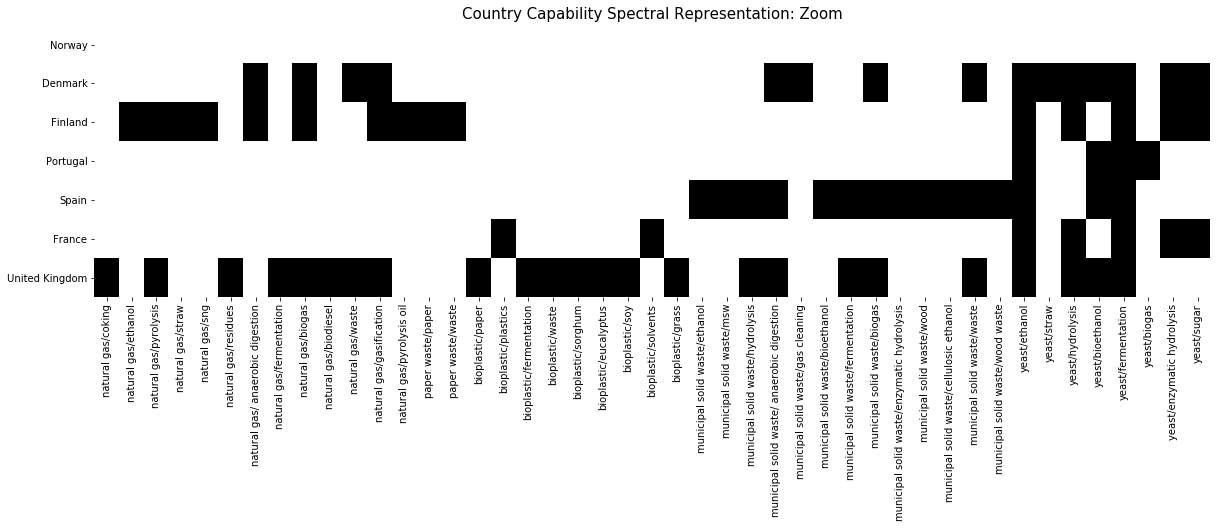

In [55]:
# define countries
scope_countries = ['Norway', 'Denmark', 'Finland', 'Portugal', 'Spain', 'France', 'United Kingdom']

# create heatmap and names of capability terms array
scope_matrix = np.zeros((len(scope_countries), len(get_country_values('Denmark'))))
capability_pair_names = np.asarray(get_country_values('root'))

# build the matrix
for i in range(len(scope_countries)):
    scope_matrix[i, :] = get_country_values(scope_countries[i])

# detect if a certain term pair is not used at all by computing the column sum
column_sum = np.sum(scope_matrix, axis=0)
zero_counter = 0
zero_indexes_array = []
for i in range(len(column_sum)):
    if column_sum[i] == 0.0:
        zero_counter += 1
        zero_indexes_array.append(i)

# delete the empty term pairs
print 'The original shape was of {} countries and {} term pairs.'.format(scope_matrix.shape[0], scope_matrix.shape[1])
print '{}% of the term pairs were empty.'.format(zero_counter * 100 / len(column_sum))
scope_matrix = np.delete(scope_matrix, zero_indexes_array, 1) 
capability_pair_names = np.delete(capability_pair_names, zero_indexes_array)
print 'The final shape is of {} countries and {} term pairs.'.format(scope_matrix.shape[0], scope_matrix.shape[1])


# limit the visualization
limit = 45
print 'Here, reduced to {} for visualization purposes.'.format(limit)

plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(scope_matrix[:, 0:limit],cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=scope_countries, xticklabels=capability_pair_names[0:limit])
plt.title('Country Capability Spectral Representation: Zoom', size=15)
plt.show()

Here, a black marker simply means that the country possesses an asset that countains that term pair. 

### 5.2. Country Spectrums: Limited Countries <a class="anchor" id="five-two"></a>

Let us plot the full spectrum for these countries, keep in mind that the quantity of term pairs is important. 

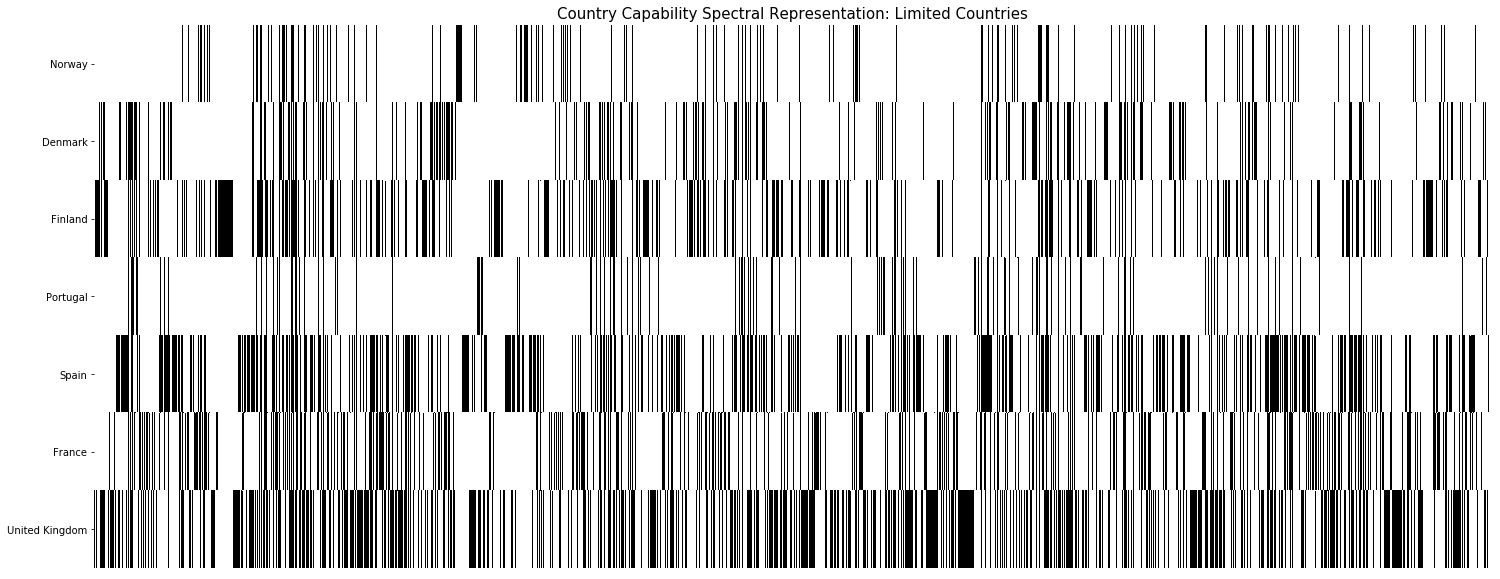

In [56]:
plt.subplots(1,1,figsize=(25, 10))
plt.subplot(111)
sns.heatmap(scope_matrix,cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=scope_countries, xticklabels=False)
plt.title('Country Capability Spectral Representation: Limited Countries', size=15)
plt.show()

Finally, let us try to map out all of the countries. 

### 5.3. Country Spectrums: Full Representation <a class="anchor" id="five-three"></a>

The original shape was of 76 countries and 123904 term pairs.
94% was empty.
The new shape was of 76 countries and 6236 term pairs.


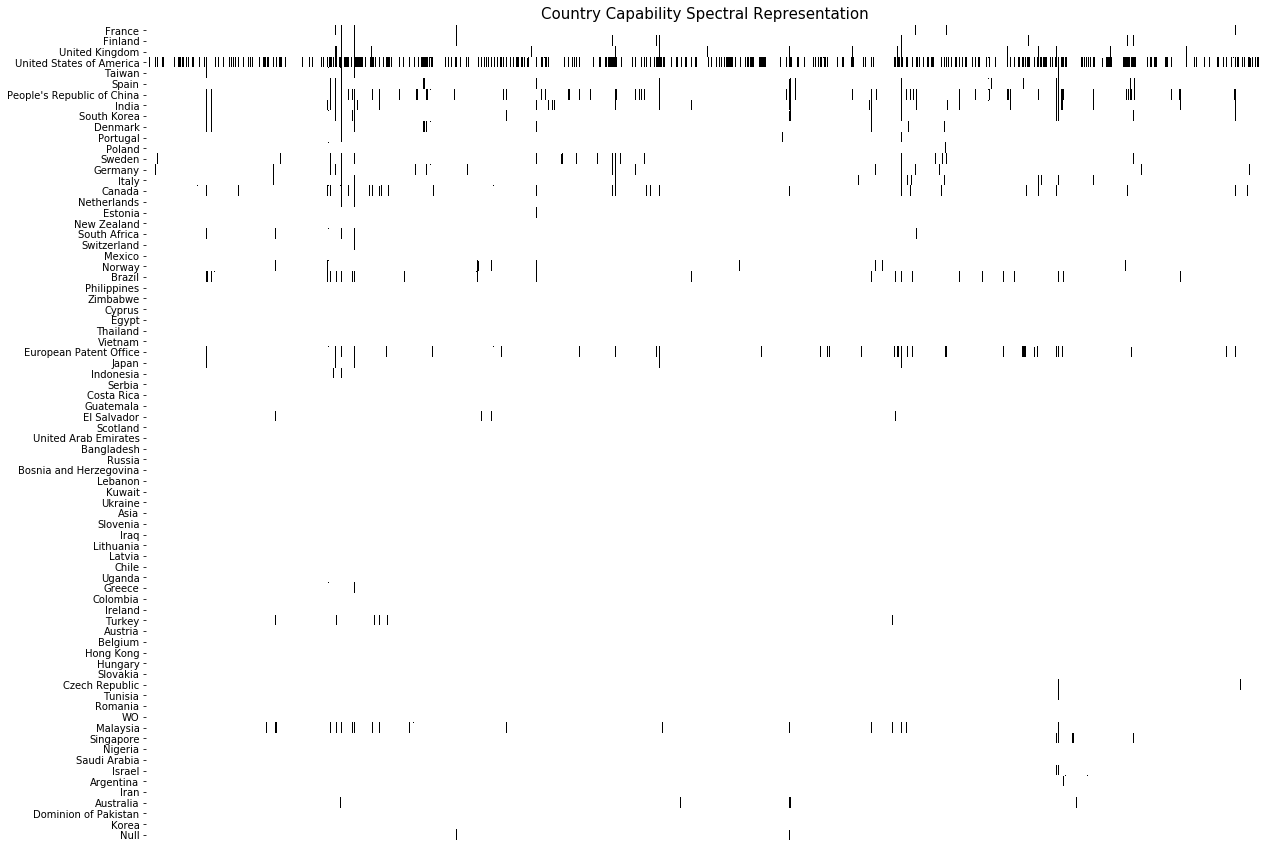

In [57]:
# redefine countries
list_of_countries = [country_names[i] for i in list(np.load('Data/cluster_country_order.npy'))]



# prepare heatmap
jumbo_matrix = np.zeros((len(list_of_countries), len(get_country_values('Denmark'))))

# build heatmap                 
for i in range(len(list_of_countries)):
    jumbo_matrix[i, :] = get_country_values(list_of_countries[i])
                        
# delete 0 entries
column_sum = np.sum(jumbo_matrix, axis=0)
zero_counter = 0
zero_indexes_array = []
for i in range(len(column_sum)):
    if column_sum[i] == 0.0:
        zero_counter += 1
        zero_indexes_array.append(i)

# adjust size to empy cells and output info
print 'The original shape was of {} countries and {} term pairs.'.format(jumbo_matrix.shape[0], jumbo_matrix.shape[1])
print '{}% was empty.'.format(zero_counter * 100 / len(column_sum))
jumbo_matrix = np.delete(jumbo_matrix, zero_indexes_array, 1) 
print 'The new shape was of {} countries and {} term pairs.'.format(jumbo_matrix.shape[0], jumbo_matrix.shape[1])

plt.subplots(1,1,figsize=(20, 15))
plt.subplot(111)
sns.heatmap(jumbo_matrix,cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=list_of_countries, xticklabels=False)
plt.yticks(rotation=0)
plt.title('Country Capability Spectral Representation', size=15)
plt.show()

### 5.4. Country Spectrums: Pairs with more than X occurency <a class="anchor" id="five-four"></a>

There were 4451 term pairs with less than 2 countries using them. 
The final shape is of 76 countries and 1785 term pairs.


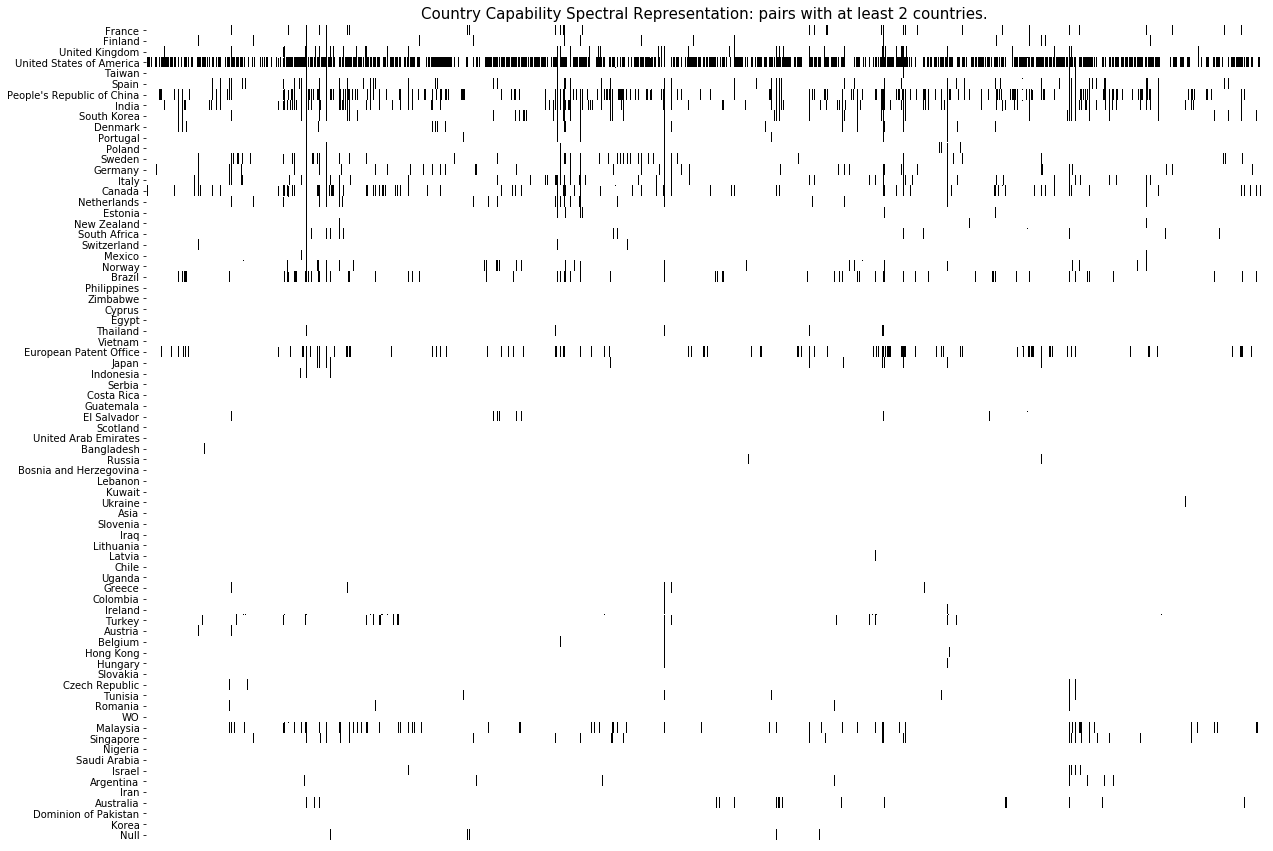

In [58]:
country_threshold = 2


col_with_low_countries = []
col_good = []
for n_col in range(jumbo_matrix.shape[1]):
    countries_with_pair = 0
    for n_row in range(jumbo_matrix.shape[0]):
        if jumbo_matrix[n_row, n_col] > 0:
            countries_with_pair += 1
    if countries_with_pair <= country_threshold:
        col_with_low_countries.append(n_col)
    else:
        col_good.append(n_col)

        
print 'There were {} term pairs with less than {} countries using them. '.format(len(col_with_low_countries), country_threshold)
jumbo_matrix = np.delete(jumbo_matrix, col_with_low_countries, 1) 
print 'The final shape is of {} countries and {} term pairs.'.format(jumbo_matrix.shape[0], jumbo_matrix.shape[1])


plt.subplots(1,1,figsize=(20, 15))
plt.subplot(111)
sns.heatmap(jumbo_matrix,cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=list_of_countries, xticklabels=False)
plt.yticks(rotation=0)
plt.title('Country Capability Spectral Representation: pairs with at least {} countries.'.format(country_threshold), size=15)
plt.show()

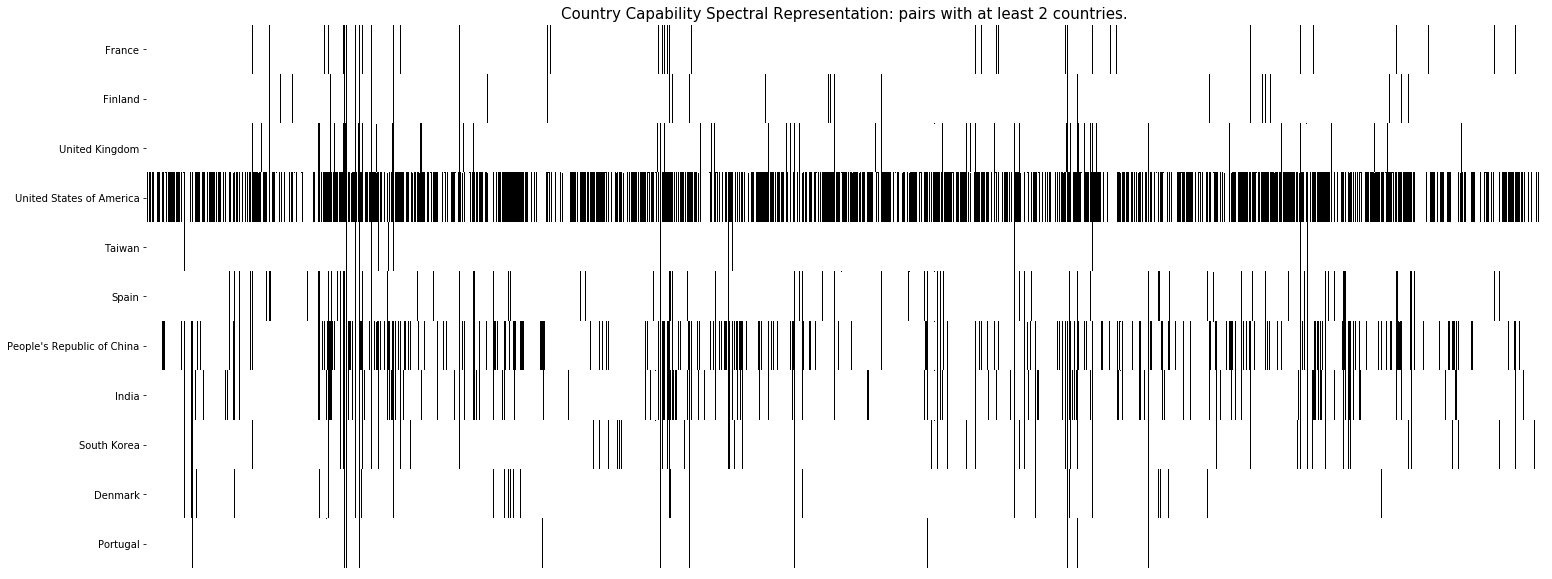

In [59]:
country_limit = 11
plt.subplots(1,1,figsize=(25, 10))
plt.subplot(111)
sns.heatmap(jumbo_matrix[0:country_limit, :],cmap=ListedColormap(['white', 'black']), center=0.01, cbar=None, square=False, yticklabels=list_of_countries[0:country_limit], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Country Capability Spectral Representation: pairs with at least {} countries.'.format(country_threshold), size=15)
plt.show()

### 5.5. The uniqueness of countries <a class="anchor" id="five-four"></a>

In [60]:
# prepare heatmap
jumbo_matrix = np.zeros((len(list_of_countries), len(get_country_values('Denmark'))))
capability_pair_names = np.asarray(get_country_values('root'))

# build heatmap                 
for i in range(len(list_of_countries)):
    jumbo_matrix[i, :] = get_country_values(list_of_countries[i])    

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning:

invalid value encountered in divide



In [61]:
# delete 0 entries
column_sum = np.sum(jumbo_matrix, axis=0)
zero_counter = 0
zero_indexes_array = []
for i in range(len(column_sum)):
    if column_sum[i] == 0.0:
        zero_counter += 1
        zero_indexes_array.append(i)

# adjust size to empy cells and output info
print 'After deleting pairs with no occurencies:'
print 'The original shape was of {} countries and {} term pairs.'.format(jumbo_matrix.shape[0], jumbo_matrix.shape[1])
print '{}% was empty.'.format(zero_counter * 100 / len(column_sum))
jumbo_matrix = np.delete(jumbo_matrix, zero_indexes_array, 1) 
capability_pair_names = np.delete(capability_pair_names, zero_indexes_array)
print 'The new shape was of {} countries and {} term pairs.'.format(jumbo_matrix.shape[0], jumbo_matrix.shape[1])

After deleting pairs with no occurencies:
The original shape was of 76 countries and 123904 term pairs.
94% was empty.
The new shape was of 76 countries and 6236 term pairs.


**Capability pairs that only appear in one country:**

In [62]:
pair_must_appear_in = 1
unique_country = 'Denmark'
number_of_unique_pairs = 0

print 'Pairs that only appear in {}:'.format(unique_country)
print ''

for column in range(len(capability_pair_names)):
    name_of_pair = capability_pair_names[column]
    counter = 0
    countries_have_it = []
    for row in range(len(list_of_countries)):
        if jumbo_matrix[row, column] > 0.0:
            counter += 1
            countries_have_it.append(list_of_countries[row])
            

    if counter == pair_must_appear_in and unique_country in countries_have_it:
        number_of_unique_pairs += 1
        
        print name_of_pair, countries_have_it, counter

print ''
print '{} has {} unique pairs.'.format(unique_country, number_of_unique_pairs)

Pairs that only appear in Denmark:

sewage/gas cleaning [u'Denmark'] 1
ethanol/garden waste [u'Denmark'] 1
ethanol/various grasses [u'Denmark'] 1
straw/garden waste [u'Denmark'] 1
straw/various grasses [u'Denmark'] 1
hydrolysis/garden waste [u'Denmark'] 1
hydrolysis/various grasses [u'Denmark'] 1
gas cleaning/industrial waste [u'Denmark'] 1
fermentation/mixed biomass [u'Denmark'] 1
rapeseed oil/solvents [u'Denmark'] 1
garden waste/various grasses [u'Denmark'] 1
garden waste/enzymatic hydrolysis [u'Denmark'] 1
garden waste/waste [u'Denmark'] 1
garden waste/grass [u'Denmark'] 1
biogas/cellulosic ethanol [u'Denmark'] 1
biogas/mixed biomass [u'Denmark'] 1
various grasses/enzymatic hydrolysis [u'Denmark'] 1
various grasses/waste [u'Denmark'] 1
various grasses/grass [u'Denmark'] 1
cellulosic ethanol/mixed biomass [u'Denmark'] 1
solvents/rapeseed [u'Denmark'] 1

Denmark has 21 unique pairs.


**Countries with the most unique pairs:**

We create a function that given a country returns the number of total pairs that country and the number of pairs that are unique to that country.

In [63]:
def number_of_unique_pairs(unique_country):
    pair_must_appear_in = 1
    number_of_unique_pairs = 0
    total_pairs = 0


    for column in range(len(capability_pair_names)):
        name_of_pair = capability_pair_names[column]
        counter = 0
        countries_have_it = []
        for row in range(len(list_of_countries)):
            if jumbo_matrix[row, column] > 0.0:
                if list_of_countries[row] == unique_country:
                    total_pairs += 1
                counter += 1
                countries_have_it.append(list_of_countries[row])
    
        if counter == pair_must_appear_in and unique_country in countries_have_it:
            number_of_unique_pairs += 1
            
    return (number_of_unique_pairs, total_pairs)

In [64]:
print '{} has {} pairs which {} are unique.'.format('Portugal', number_of_unique_pairs('Portugal')[1], number_of_unique_pairs('Portugal')[0])

Portugal has 139 pairs which 10 are unique.


Let us define the uniqueness of a country as its proportion of unique pairs in relation to total pairs. 

In [65]:
def country_uniqueness(country):
    division =  float(number_of_unique_pairs(country)[0]) / number_of_unique_pairs(country)[1]
    return division

Let us create the uniqueness ranking:

In [66]:
# create dataframe
term_Dataframe = pd.DataFrame(
    {'Country': [country for country in list_of_countries],
     'Uniqueness': [country_uniqueness(country) for country in list_of_countries], 
     'Unique Pairs': [number_of_unique_pairs(country)[0] for country in list_of_countries], 
     'Total Pairs': [number_of_unique_pairs(country)[1] for country in list_of_countries]
    })

# prepare dataframe
term_Dataframe = term_Dataframe[['Country', 'Uniqueness', 'Unique Pairs', 'Total Pairs']]
term_Dataframe = term_Dataframe.sort_values('Uniqueness', ascending=False)


# print everything
display(HTML(term_Dataframe[:20].to_html(index=False)))

Country,Uniqueness,Unique Pairs,Total Pairs
United States of America,0.477474,2215,4639
Ukraine,0.263158,5,19
Indonesia,0.210526,12,57
Lebanon,0.200000,1,5
Bangladesh,0.200000,7,35
Cyprus,0.157895,3,19
Sweden,0.156250,70,448
Austria,0.150685,11,73
European Patent Office,0.140145,155,1106
El Salvador,0.132530,11,83


In [67]:
dk = 'Denmark'
print '{} has an uniqueness of {} with {} pairs of which {} are unique.'.format(dk, country_uniqueness(dk), number_of_unique_pairs(dk)[1], number_of_unique_pairs(dk)[0])

Denmark has an uniqueness of 0.08203125 with 256 pairs of which 21 are unique.


**Country word clouds:**

In [68]:
country_for_cloud = 'Uganda'
index_for_cloud = list_of_countries.index(country_for_cloud)
jumbo_array = jumbo_matrix[index_for_cloud, :]
string = ''
pair_counter = 0

for i in range(len(capability_pair_names)):
    if jumbo_array[i] > 0.0:
        pair_counter += 1
        string += ' {}'.format(capability_pair_names[i].replace('/', ' '))

print '{} has {} term pairs.'.format(country_for_cloud, pair_counter)

Uganda has 23 term pairs.


Uganda cloud:


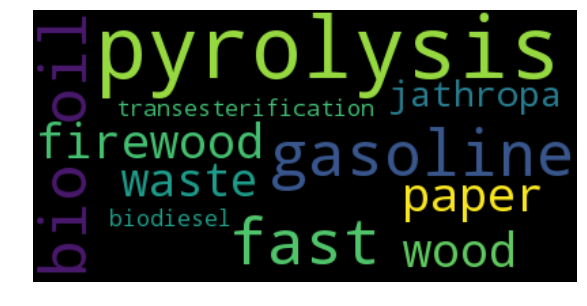

In [69]:
text = string

wordcloud = WordCloud().generate(text)

print '{} cloud:'.format(country_for_cloud)
plt.subplots(1,1,figsize=(15, 5))
plt.subplot(111)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()